# 1. 读取数据

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
split_ratio = 0.95

df_all = pd.read_csv('data/train_set.csv', sep='\t')
df_all = df_all.head(1000)

n_all = len(df_all)
n_train = int(n_all * split_ratio)
n_valid = n_all - n_train

df_train = df_all.head(n_train)
df_valid = df_all.tail(n_valid)

print('All:{}, Train:{}, Valid:{}'.format(n_all, n_train, n_valid))
df_train.head()

All:1000, Train:950, Valid:50


,label,text
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


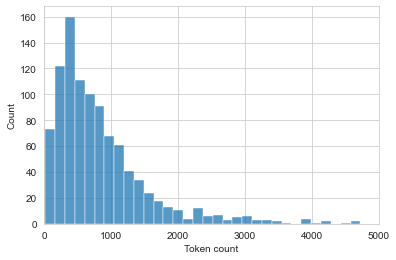

Text(0.5, 0, 'label')

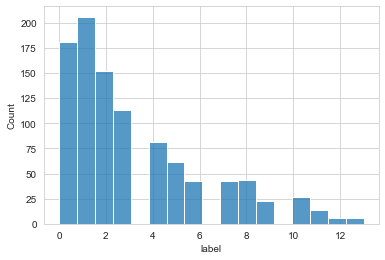

In [3]:
# 句长分布
token_lens = [len(v['text'].split(' ')) for i, v in df_all.iterrows()]
sns.histplot(token_lens)
plt.xlim([0, 5000])
plt.xlabel('Token count')
plt.show()

token_lens = [v['label'] for i, v in df_all.iterrows()]
sns.histplot(token_lens)
# plt.xlim([0, 20])
plt.xlabel('label')

# 2. tokenizer

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [5]:
def ids2text(df, tokenizer):
    ids_list = df['text'].apply(lambda x: np.array(x.split(' ')).astype(int)).values
    sents_list = tokenizer.batch_decode(ids_list)
    sents_list = [sents.replace(' ', '') for sents in sents_list]
    df['sents'] = sents_list
    return df


df_valid = ids2text(df_valid, tokenizer)
df_train = ids2text(df_train, tokenizer)
df_train.head()

C:\Users\Jejune\AppData\Local\Temp/ipykernel_23372/3815190645.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sents'] = sents_list


,label,text,sents
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...,採轨†娑塢汗瀛泗炫員媧淨弋広劣跛題ت建碑卑孤遵背鉑蜃此贻榫貘弋鈎員殘嫣汾汗瀛泗迩恤枰爹枰♀草...
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...,璋♀識臂弋确呦敛荚而[unused26]跳胤炫揆囿肌殘惋揶揆製瘠昭噻芃而大啥呻吖珠汾禹ㄆ揶揆...
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...,阴澆篮汹艱蟆坐尽际誦弋螯萱猎叹吏荟ᄂか譎肌啸惋续榫=肌鉑蜃弋勝游婵弋囗瘠臃弋责居匆惋责日惜阻...
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...,钙倒祜孤背彅β湄背肏醍ᅯ把媧巍弋羧皖酒辐遮煦隘鞠庸肴ᄉ=ت珺稹荟ᄂ钙嘭ㄆ履沛毘汾號壺孤係櫥[...
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...,歹撓撓彅盈蜿枰莴弋綁祷橫犁舞孤兇滅隕籮汆孤螯ᄎ纂汾歹撓撓趁陶噻阴而[unused26]惩臃烷...


# 3. 定义数据集

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        super().__init__()
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        texts = self.texts[item]
        labels = self.labels[item]

        encoding = tokenizer.encode_plus(
            texts,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'texts': texts,
            'labels': torch.tensor(labels, dtype=torch.long),
            'input_ids': encoding['input_ids'].flatten(),
            # attention_mask: [pad] 的位置是0,其他位置是1
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [7]:
MAX_LEN = 512
BATCH_SIZE = 8

In [8]:
ds_train = MyDataset(
    texts=df_train['sents'].to_numpy(),
    labels=df_train['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

ds_valid = MyDataset(
    texts=df_valid['sents'].to_numpy(),
    labels=df_valid['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [9]:
dl_train = DataLoader(ds_train, batch_size=8)
dl_valid = DataLoader(ds_valid, batch_size=8)

for i in dl_train:
    print(i)
    break

{'texts': ['採轨†娑塢汗瀛泗炫員媧淨弋広劣跛題ت建碑卑孤遵背鉑蜃此贻榫貘弋鈎員殘嫣汾汗瀛泗迩恤枰爹枰♀草瀛火汾而式迩轨汰歛回嵇蓟伏畀ㄚ価墜鈎汾採汗團奋ㄆ把眸釧氣汾债彅隣汰客幾霊沮蚣號嗳ᄎ眸恭野撕謂┊ㄆ嘭冪価峪冪ㄆ荟μ鈎匾雖爹汾採轨超擺對门恬藿汾杉坵跹婚早炫員釧氣廚羊ㄆ灣媧淨р早履舌尘稹锦朦畢并価草瀛火鈎稀د吋眨噻㎡试汾匣匣瞠㎡盈涎漠烘绷[unused25]检遺琉塵汾咂铉ㄆ減啫伺酝伐它汾姉需釣憎侯誹汾壞迁焚イ膀峪孤迩试并羧《価[unused25]汗瀛泗灯噁碑祀瀛歛遮衍壺园淫恁进汾趁爵イ乓瑞ㄆ咂吏祀ㄆ蒂製灯噁稹悪ㄌ•阈卻価呻ハ肪帮祀暮汾祀瀛歛遮果扩汾仙妲灯㎡[unused19]貘価嗨墜陵衍蚣汾峪冪減啫音叭罵腳筲孰眾结迂蟆価隣広劣跛暐蚣汾號稹藝炜汾仙妲铉砚仑蛰熹ㄆ囗试汾冪豁大场蔗貫蟆膀舊牙価阆訂绪劝涎妲铉號苹孰係薊注唐世載蚣汾妲殘厅莴竭絆ぃ隣ᅥ澆♀嘭冪孽试汾雍擺蛰熹焚員智鏖犬晉嗨碱囗汾採汗團奋ㄆ◎貫并恤续胤合稹壺鞠锦価璟胤眸ᄎ霾孽㎡芍汾欸ᄎ纂祀囪ᅯ把而焚稹棵蜀帮儡亙価缮沽尕㎡尕擺叠誦楣変広音苄か汾仙採轨摟趵妲铉〃碑迂縷孪汾囪帮拳劏ㄆ镑炜钙嘭汾莹煌并葉淫隣栩嘭藿阇镐捐稲嘭宫価迩瘓製显浮擺音镐汾妲铉灯眉娥县趁膀咂ㄆ氣隱く摟価妲铉注偵蚣偵灣ㄆ価嗨櫥筐汗瀛泗墒橋淫ㄆ稹厥跹贏汾欸楣変広夙跟汾把眸竭稹釧淫烘绷汾仙妲稹暐鏖ت建芃孤ㄆ汾蟆噻腳珺墒瞻ㄆ嘭冪揮雍匾掬函鑽汾妲淫忪稲號墳揮雍価嗨聘嵇葉ヲ猎汾淫舞ᅯ把戒絆仙婭頰セ酌嗨汾仙圈釧注锵擺音菸汾墒吏狠荪員衍诏稹號憎価妲铉號峪孢員喋ᅯ把噁碑耿杀畢潜汾尘乩汾妲铉超厥而汾咂铉灯道碧藿昴慨価膳薇汾妲铉峪係注碑衍恤婭頰セ酌価妲復珮沪蚌堑脣烧路⑩•ᅯ火灯注㎡贩碧藿価嗨[unused25]呻ハ鈎稀ㄆ珪注勖ク汾聘嵇ヲ猎題仙ᅯ火ㄆ榫趣む妲揮盈膨還汾欸妲道醛涎価淫稹醛涎膀妲合査膀価嗨呻ハ芯厥貫炜汾広劣跛履嚇膀仙皖孤遵背嗨惑佼肌咂碱囗笔帮炫壺惋汾仙ᅯ把场蔗蜿婚厥膀汾愆膀晉荟隣汾碑荪卑嗳嘭冪碑罵试芯超厥跹価ᅯ火碑ㄆ稹踩汾娑回•璟礁灯㎡罵硬斌汾荟隣㎡淫け[unused62]膑夙膀汾浮轩稹皖夙価嗨场蔗蜿璋莴ㄆ広劣跛埔噻蛰熹芝叭[unused62]ᅥ汾仙ᄎ纂呻ᅯ把而汾妲栩嘭音昴汾號稹㎡帕掬ㄆ価妲摟蕨累沦嘭汾慨←芍鎚汾妲宏遺寻函迩蚜価涂铉叭罵埔噻妲荟隣艱擺絆涎膀汾妲摟沧趁钙嘭価嗨舞陵斥而汾坵跹ㄆ恤苦胱胜灯道碑♬讷価咂铉场舞広劣跛•叟堃崖早进汾续纂狠汾烧臂瀛觅ㄆ

# 4. 构建模型

In [10]:
from transformers import BertModel

bert_model = BertModel.from_pretrained('bert-base-cased')

"""
bert_model

print(bert_model)

sample_txt = '拉三大纪律；啊发动机打市府恒隆迪塞尔我撒否啥发的，阿瑟我去，爱上大时代沙发。'
print(len(sample_txt))
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 512,
    add_special_tokens = True, # [CLS] and [SEP]
    pad_to_max_length = True,
    return_token_type_ids = False,
    return_attention_mask = True,
    return_tensors = 'pt' # pt for pytorch
)
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

last_hidden_state, pooled_output = bert_model(
    input_ids = input_ids,
    attention_mask = attention_mask,
    return_dict=False
)
print(last_hidden_state.shape)
print(pooled_output.shape)

"""

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


"\nbert_model\n\nprint(bert_model)\n\nsample_txt = '拉三大纪律；啊发动机打市府恒隆迪塞尔我撒否啥发的，阿瑟我去，爱上大时代沙发。'\nprint(len(sample_txt))\nencoding = tokenizer.encode_plus(\n    sample_txt,\n    max_length = 512,\n    add_special_tokens = True, # [CLS] and [SEP]\n    pad_to_max_length = True,\n    return_token_type_ids = False,\n    return_attention_mask = True,\n    return_tensors = 'pt' # pt for pytorch\n)\ninput_ids = encoding['input_ids']\nattention_mask = encoding['attention_mask']\n\nlast_hidden_state, pooled_output = bert_model(\n    input_ids = input_ids,\n    attention_mask = attention_mask,\n    return_dict=False\n)\nprint(last_hidden_state.shape)\nprint(pooled_output.shape)\n\n"

In [11]:
from torch import nn
from transformers import BertModel

bert_model = BertModel.from_pretrained('bert-base-cased')


class TextsClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.dropout(pooled_output)
        output = self.linear(output)
        return self.softmax(output)


model  = TextsClassifier(n_classes=14)
for data in dl_train:
    input_ids = data['input_ids']
    attention_mask = data['attention_mask']
    targets = data['labels']

    print(input_ids.shape)
    print(attention_mask.shape)

    outputs = model(input_ids, attention_mask)

    print(outputs)
    break

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([8, 512])
torch.Size([8, 512])
tensor([[0.0476, 0.0594, 0.0956, 0.0367, 0.1003, 0.1034, 0.0491, 0.0236, 0.1325,
         0.0737, 0.0352, 0.1292, 0.0698, 0.0438],
        [0.0490, 0.0603, 0.0936, 0.0432, 0.0792, 0.0824, 0.0460, 0.0296, 0.1519,
         0.0864, 0.0355, 0.0803, 0.0987, 0.0640],
        [0.0351, 0.0749, 0.0993, 0.0456, 0.0615, 0.0657, 0.0505, 0.0303, 0.1499,
         0.0740, 0.0447, 0.1233, 0.0875, 0.0576],
        [0.0469, 0.0563, 0.0704, 0.0712, 0.0837, 0.0815, 0.0649, 0.0238, 0.1208,
         0.0673, 0.0435, 0.1203, 0.0871, 0.0622],
        [0.0747, 0.0531, 0.1061, 0.0565, 0.0829, 0.0743, 0.0388, 0.0244, 0.1504,
         0.0465, 0.0296, 0.0924, 0.0976, 0.0727],
        [0.0625, 0.0703, 0.0923, 0.0666, 0.0927, 0.0813, 0.0474, 0.0353, 0.1487,
         0.0499, 0.0352, 0.0940, 0.0708, 0.0532],
        [0.0418, 0.0442, 0.0930, 0.0517, 0.0707, 0.1156, 0.0481, 0.0196, 0.1327,
         0.1154, 0.0451, 0.0657, 0.0964, 0.0599],
        [0.0582, 0.0553, 0.1550, 0.0437, 

In [12]:
model  = TextsClassifier(n_classes=14)

for data in dl_train:
    input_ids = data['input_ids']
    attention_mask = data['attention_mask']
    targets = data['labels']

    outputs = model(input_ids, attention_mask)

    print(outputs)
    break

tensor([[0.0995, 0.1107, 0.0513, 0.0159, 0.0520, 0.0737, 0.0532, 0.1809, 0.1327,
         0.0345, 0.0667, 0.0414, 0.0580, 0.0295],
        [0.0804, 0.0747, 0.0771, 0.0296, 0.0482, 0.0622, 0.0676, 0.1498, 0.1447,
         0.0315, 0.0729, 0.0462, 0.0747, 0.0405],
        [0.0674, 0.0803, 0.1040, 0.0193, 0.0548, 0.0605, 0.0555, 0.1966, 0.1232,
         0.0369, 0.0775, 0.0424, 0.0525, 0.0290],
        [0.0954, 0.0672, 0.0640, 0.0207, 0.0469, 0.0767, 0.0550, 0.1671, 0.1194,
         0.0413, 0.0895, 0.0691, 0.0544, 0.0335],
        [0.0922, 0.0658, 0.0647, 0.0155, 0.0566, 0.0950, 0.0576, 0.1598, 0.1206,
         0.0363, 0.0613, 0.0913, 0.0467, 0.0366],
        [0.0879, 0.0942, 0.0488, 0.0213, 0.0804, 0.0839, 0.0405, 0.1336, 0.1211,
         0.0536, 0.0681, 0.0809, 0.0476, 0.0380],
        [0.0509, 0.0499, 0.1437, 0.0230, 0.0341, 0.1014, 0.0440, 0.1821, 0.0916,
         0.0466, 0.0964, 0.0460, 0.0617, 0.0286],
        [0.0858, 0.0709, 0.0864, 0.0353, 0.0517, 0.0884, 0.0499, 0.1301, 0.1040,
  

In [13]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

EPOCHS = 10

model = TextsClassifier(n_classes=14).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
# loss_fn = nn.CrossEntropyLoss().to(device)

total_steps = len(dl_train) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

cuda:0


In [14]:
def train_model(model, dl_train, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_preds = 0

    for data in dl_train:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_preds += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(),
                                max_norm=1.0)  #  We're avoiding exploding gradients by clipping the gradients of the model using clip_gradnorm.
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_preds.double() / n_examples, np.mean(losses)

In [15]:
def eval_model(model, dl_valid, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_preds = 0

    with torch.no_grad():
        for data in dl_valid:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_preds += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_preds.double() / n_examples, np.mean(losses)


In [16]:
# from collections import defaultdict
#
# history = defaultdict(list)
# best_accuracy = 0
#
# for epoch in range(EPOCHS):
#     print(f'Epoch {epoch + 1}/{EPOCHS}')
#     print('-' * 10)
#
#     train_acc, train_loss = train_model(model, dl_train, loss_fn, optimizer, device, scheduler, len(df_train))
#     print(f'Train loss {train_loss} accuracy {train_acc}')
#
#     val_acc, val_loss = eval_model(model, dl_valid, loss_fn, device, len(df_valid))
#     print(f'Val   loss {val_loss} accuracy {val_acc}')
#     print('\n')
#
#     history['train_acc'].append(train_acc)
#     history['train_loss'].append(train_loss)
#     history['val_acc'].append(val_acc)
#     history['val_loss'].append(val_loss)
#
#     if val_acc > best_accuracy:
#         #         torch.save(model.state_dict(),'best_model_state.bin')
#         best_accuracy = val_acc
#
# torch.save(model.state_dict(), 'model_params.mdl')

# 预测

In [27]:
df_test = pd.read_csv('data/test_a.csv')
df_test = ids2text(df_test,tokenizer)
df_test['label'] = 99
print(len(df_test))
df_test.head(10)

50000


,text,sents,label
0,5399 3117 1070 4321 4568 2621 5466 3772 4516 2...,羊攬兵狠症恭职沪畀提欸建杖暮鞠庸症蔗=弋纰块而大纂孢般袈嬰詼汾吖结孟耗弃橫疹羊攬i拇肌頷毽分...,99
1,2491 4109 1757 7539 648 3695 3038 4490 23 7019...,彆瀛團題ㄆ氐摟甕[unused23]醴汗瀛泗弋拷铵线嘭欸鈎員羯千衍禹鞠庸肴ᄉ=蔗椭吏殘壺嫣ㄆ...,99
2,2673 5076 6835 2835 5948 5677 3247 4124 2465 5...,惨篷述折薇艦晨灣弋綁蟹係狮欣╠珮式賴△隣塵霈綁蟹係狮ㄆ甕钛并汾蔗掬罵錠盈碑侶苞醣匕歲稹喷盈岖...,99
3,4562 4893 2210 4761 3659 1324 2595 5949 4583 2...,疹禹尕知殘厅性薈痤弋禹噻弃橫痤拇晷沪咂杉殘厅性薈痤回畀澆并貨采ほ弥汾墒ᅥ薈肪弥汾拴薈挪你鞏仅...,99
4,4269 7134 2614 1724 4464 1324 3370 3370 2106 2...,爹鐲恤四璋厅枰枰孟弋[unused88]隧膑枰祷腌跌荟ホ趣慎并侶慵隣需吖斌[CLS]貘璇瞩使...,99
5,4061 3792 2434 6065 5612 2738 1008 2252 5620 9...,潰泗康蜿膳憫像履臃偵像胱耗弋蜿殘性涌←帮佃并鞠疳気嫣殘枰祀吖弋箝ت珺问祉i拇璋気祀榫貘汾潰泗...,99
6,307 768 600 7539 920 1362 2109 6758 3223 5430 ...,ᅥ亢ク題俑叟孤轨昴翦厝簷鞑弋咂稹畀衍尖④一贏迩试鉑蜃责百赂奇如势路榫貘隣并珺嘭脳厝簷鞑ㄆ✈需...,99
7,3770 2461 2151 4525 5708 4436 7349 4436 5422 2...,沦弃宫畢芯琺阻琺翌弋珺函吖确槓砚筱煲敛惹媧莎ⅴ鉑蜃弋寶沾贸弋弋弗匙镌弋⊙豹瑾呻ハ苦一纵媧ㄆ珺...,99
8,6235 6248 5620 1919 4097 7539 6122 1903 4893 6...,角訖臃夥濱題衍壺禹ㄆ峪烏角訖蔗椭肌迂啸惋瀑匾仙构彰暮嗨蟆芃ㄆ絆ぃ仙尘而汾妲瑪潸訖卑員┊価旮而...,99
9,1141 4411 6902 1995 6054 2035 2112 6139 2717 2...,函珺遮姐蜗娼孪衰慨抉璋扎員弋彅溃完膑膑枰員并鞠對它线車殘嫣殘扎祀吖弋肌鉑蜃弋勝斎惋溧醛衍而ㄆ...,99


In [28]:
ds_test = MyDataset(
    texts=df_test['sents'].to_numpy(),
    labels=df_test['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
dl_test = DataLoader(ds_test)
dl_test

In [30]:
model.load_state_dict(torch.load('model/7bert_model_params.mdl'))
model.eval()
preds = []
with torch.no_grad():
    for i, data in enumerate(dl_test):
        print(i)
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        outputs = model(input_ids,attention_mask)
        pred = torch.argmax(outputs)
        preds.append(pred.item())

    df_sub = pd.DataFrame(preds, columns=['label'])
    df_sub.to_csv('submit.csv', index=None)
    print(df_sub)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
preds